In [3]:
%matplotlib inline

import pandas as pd
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import cv2, os, random, math, glob
from base64 import b64encode

In [4]:
!wget https://gist.githubusercontent.com/f-banda/0a7448ddba470ee6009e8bbaf4751a34/raw/56d07b202921b591e8c2390048758c4b3fd3df7b/games.csv
!wget https://gist.githubusercontent.com/f-banda/0a7448ddba470ee6009e8bbaf4751a34/raw/56d07b202921b591e8c2390048758c4b3fd3df7b/plays.csv
!wget https://gist.githubusercontent.com/f-banda/0a7448ddba470ee6009e8bbaf4751a34/raw/56d07b202921b591e8c2390048758c4b3fd3df7b/players.csv
!wget https://dl.dropboxusercontent.com/s/0jvkqf9wnfjdlrf/dataTracking2020.csv

--2023-08-25 01:23:12--  https://gist.githubusercontent.com/f-banda/0a7448ddba470ee6009e8bbaf4751a34/raw/56d07b202921b591e8c2390048758c4b3fd3df7b/games.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39831 (39K) [text/plain]
Saving to: ‘games.csv’

games.csv           100%[===================>]  38.90K  --.-KB/s    in 0.005s  

2023-08-25 01:23:12 (7.90 MB/s) - ‘games.csv’ saved [39831/39831]

--2023-08-25 01:23:12--  https://gist.githubusercontent.com/f-banda/0a7448ddba470ee6009e8bbaf4751a34/raw/56d07b202921b591e8c2390048758c4b3fd3df7b/plays.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.1

In [5]:
class NFL:
  def __init__(self):
    """
    https://www.kaggle.com/competitions/nfl-big-data-bowl-2022/data
    """
    self.game_link = "games.csv"
    self.play_link = "plays.csv"
    self.player_link = "players.csv"
    self.track_link = "dataTracking2020.csv"
    self.download()

  def download(self):
    self.game = pd.read_csv(self.game_link)
    self.play = pd.read_csv(self.play_link)
    self.player = pd.read_csv(self.player_link)
    self.track = pd.read_csv(self.track_link)

  def import_pbp_data(self, ls):
    season = self.game[self.game["season"].isin(ls)]
    game = self.play[self.play["gameId"].isin(season["gameId"])]
    play = self.track
    return play

In [50]:
def modified_image(img_):
  width, height = img_.shape[0], img_.shape[1]
  # Calculate the size of the new image
  left, right = 13.05/120, (141.41-120)/120
  up, down = 7.58/53.3, (65.32-53.3)/53.3
  new_width = int(width * (1 + left + right))
  new_height = int(height * (1 + up + down))

  # Create a new image with a white background
  img = np.zeros((new_width, new_height, 3))

  # Calculate the position to paste the original image on the new image
  left = int(width * left)
  up = int(height * up)
  img[left:left+width, up:up+height, :] = img_[:, :, :]
  cv2.imwrite("img.png", img)

In [51]:
def save_play(penalty, game_id, play_id):
  nfl = NFL()
  pbp_data = nfl.import_pbp_data([2020])
  game_data = pbp_data[pbp_data["gameId"] == game_id] # Filter the data by game id
  mot = game_data[game_data["playId"] == play_id]
  img = cv2.imread('nfl.png')

  # Paste the original image onto the new image

  #mot["new_time"] = pd.to_datetime(mot["time"])
  #mot["frame"] = mot.new_time.dt.hour*60*60*1000+mot.new_time.dt.minute*60*1000+mot.new_time.dt.second*1000+mot.new_time.dt.microsecond//1000
  #65.32 -7.58
  #141.41 -13.05

  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]
  total_time = mot["frameId"].max()-mot["frameId"].min()
  min_time = mot["frameId"].min()
  fig, ax = plt.subplots(figsize=(12*2, 5.3*2))
  def animate(i):
      ax.clear()
      ax.imshow(img)
      trck = mot[mot["frameId"]==min_time+i]
      sns.scatterplot(data=trck, x="new_x", y="new_y", s=200, hue="team").legend_.remove()
      for i in range(trck.shape[0]):
        label = trck['jerseyNumber'].iloc[i]
        if math.isnan(label):
          label=0
        else:
          label = int(label)
        ax.text(trck['new_x'].iloc[i], trck['new_y'].iloc[i], str(label), ha='center', va='center', color='white')
      ax.axis('off')
  animate(0)
  # ani = animation.FuncAnimation(fig, animate, frames=total_time, interval=100)
  # os.makedirs("animations", exist_ok=True)
  # penalty_pre = penalty.split(";")[0]
  # os.makedirs("animations/"+penalty_pre, exist_ok=True)
  # ani.save("animations/"+penalty_pre+"/"+str(game_id)+"_"+str(play_id)+".mp4")

In [55]:
def find_all_penalties():
  nfl = NFL()
  season = nfl.game[nfl.game["season"].isin([2020])].gameId.unique()
  penalty_mask = nfl.play[nfl.play["gameId"].isin(season)]
  penalty_plays = penalty_mask[penalty_mask["penaltyCodes"].notnull()]
  for index, row in penalty_plays[["gameId", "playId", "penaltyCodes"]].iterrows():
    print(row.penaltyCodes, row.gameId, row.playId)
    save_play(row.penaltyCodes, row.gameId, row.playId)

FMM 2020091301 2177


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


FMM 2020091301 2590


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


IBW 2020091302 39


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


FMM 2020091302 740


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


IDT 2020091303 1996


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


UNS 2020091303 2432


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


POK 2020091304 2017


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


IBW 2020091308 2880


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


POK 2020091309 539


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


OH 2020091309 655


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


OH 2020091401 394


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


IBW 2020091401 1008


<ipython-input-51-673a4793139b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
<ipython-input-51-673a4793139b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]


IBW 2020091700 1324


AttributeError: ignored

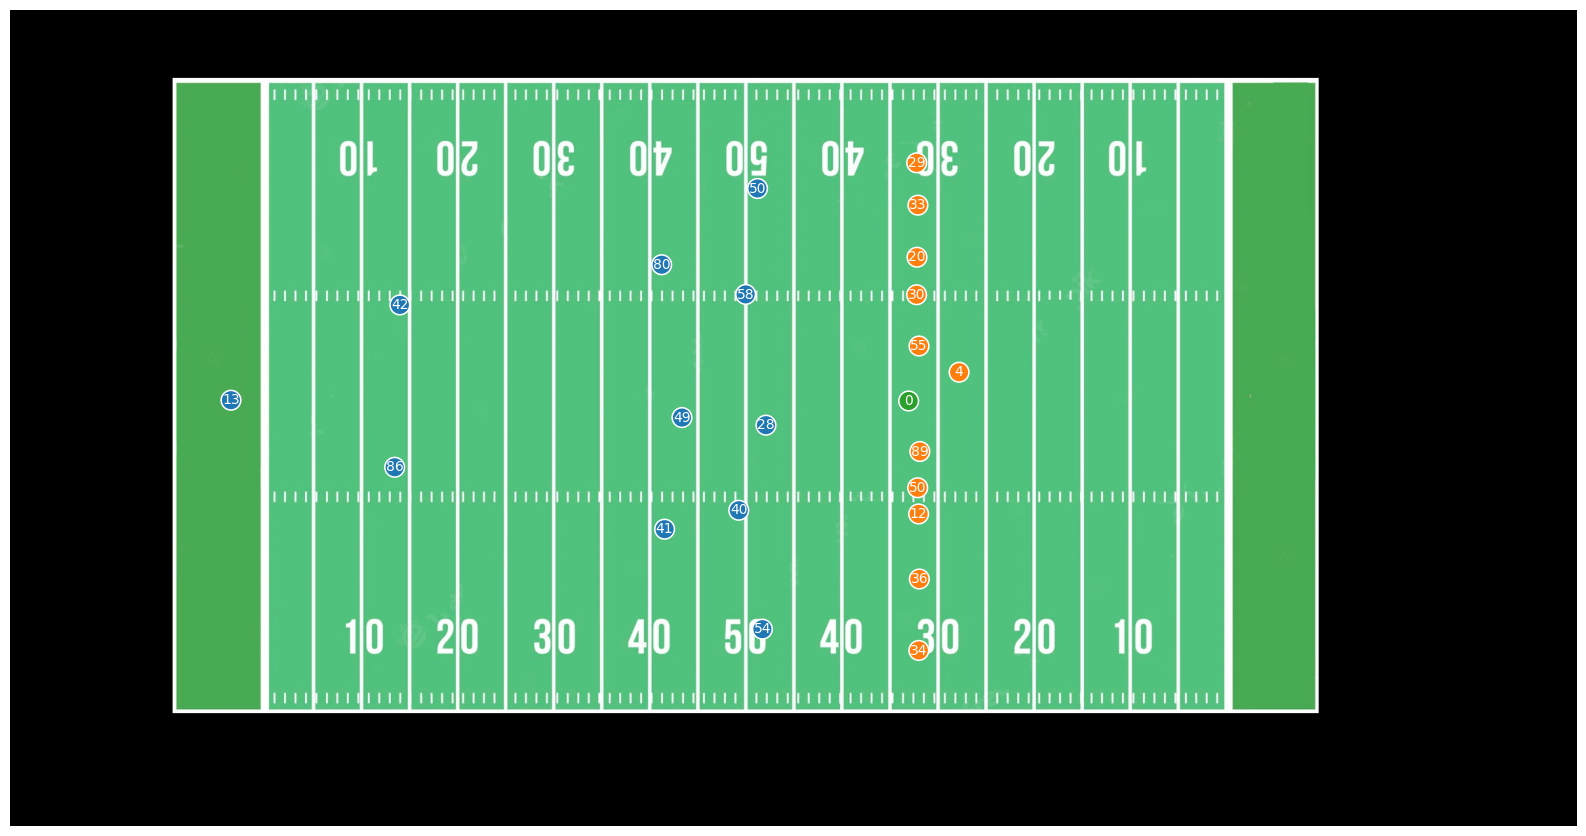

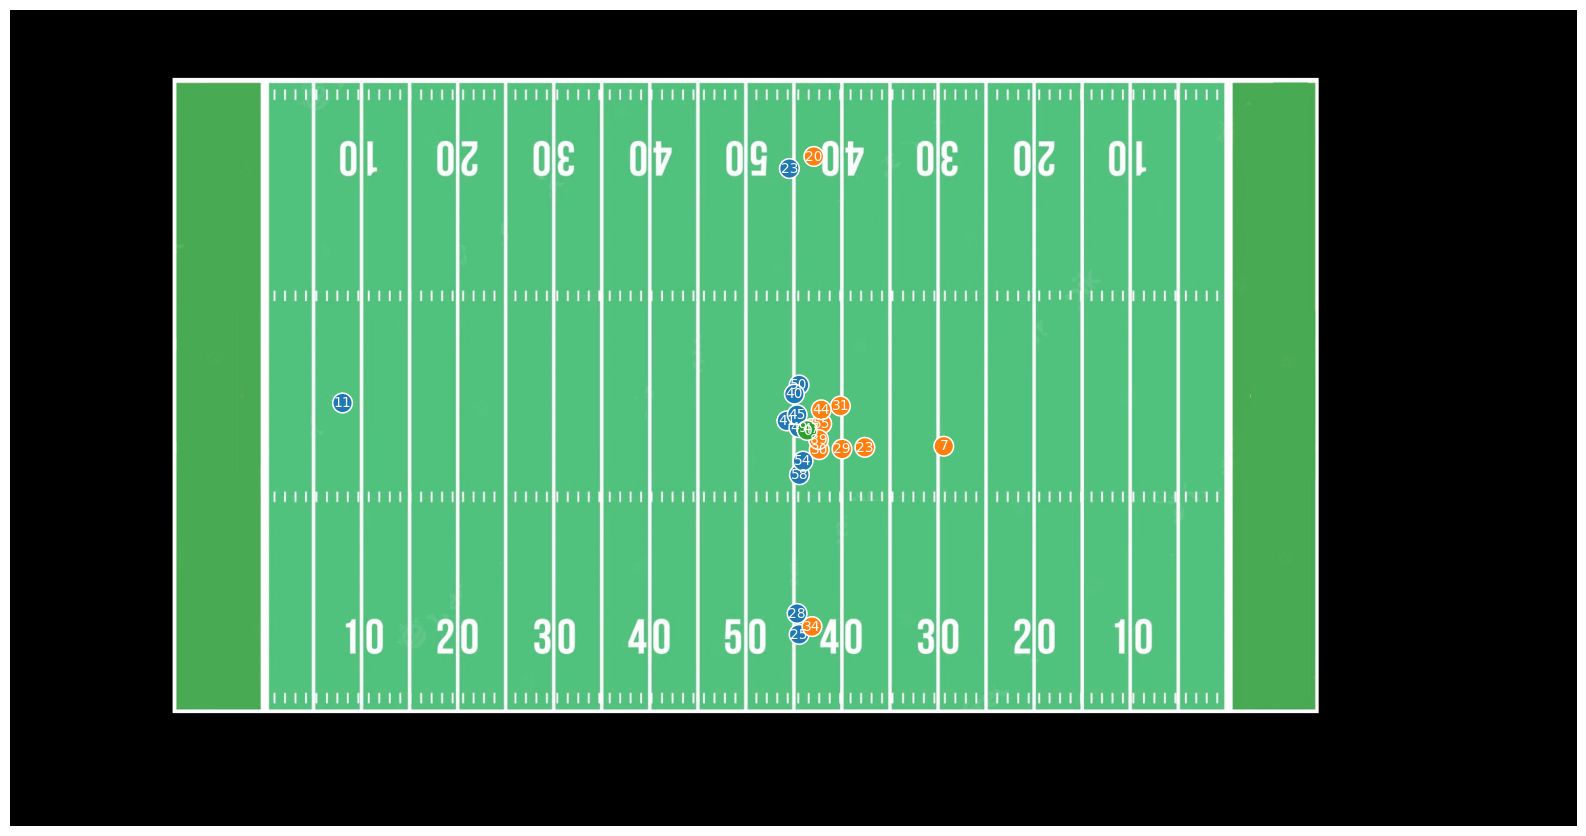

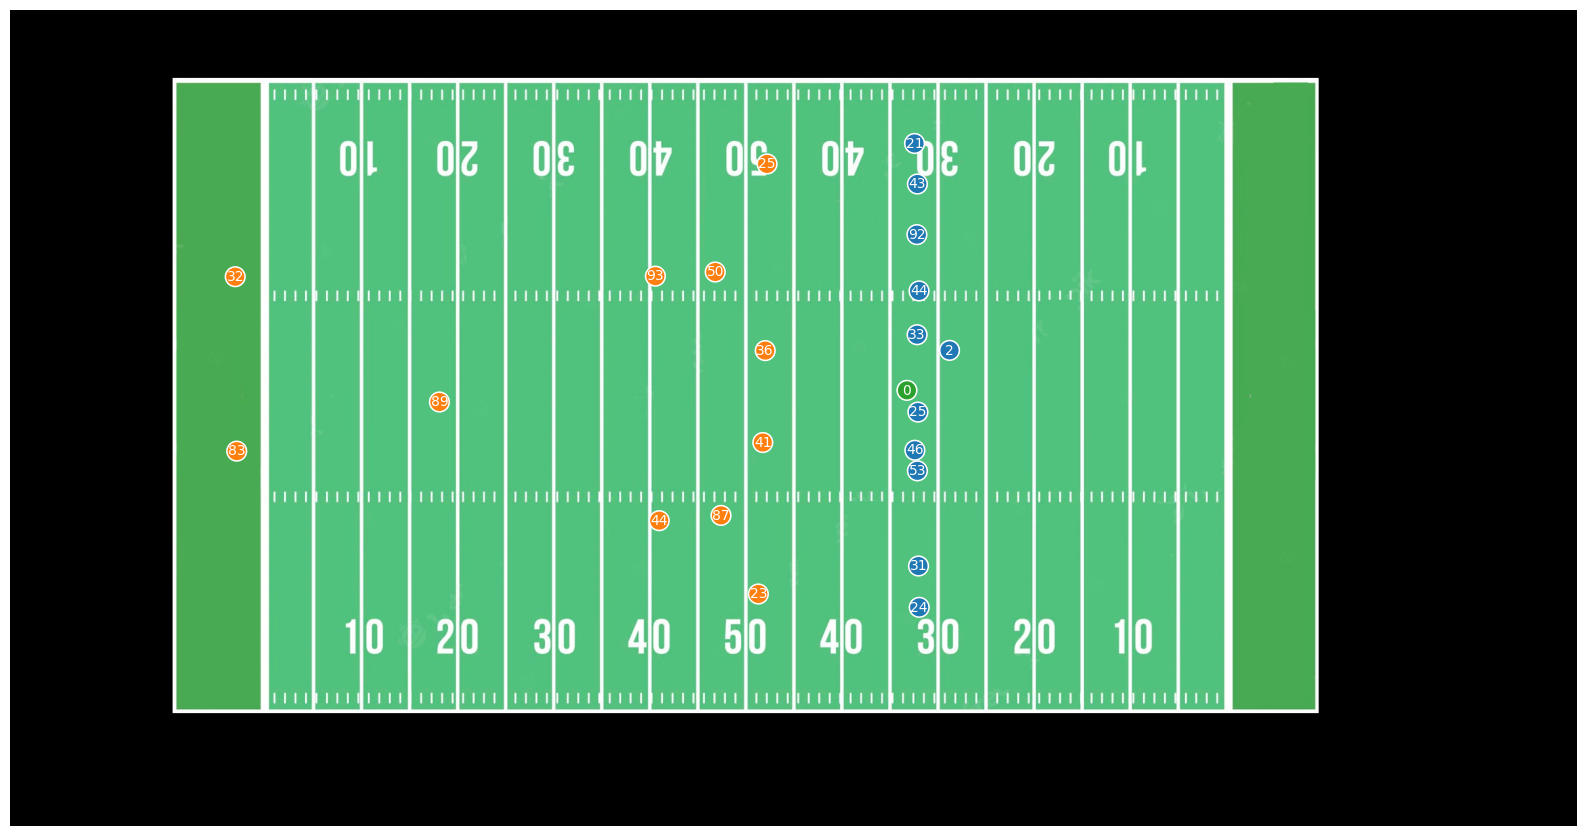

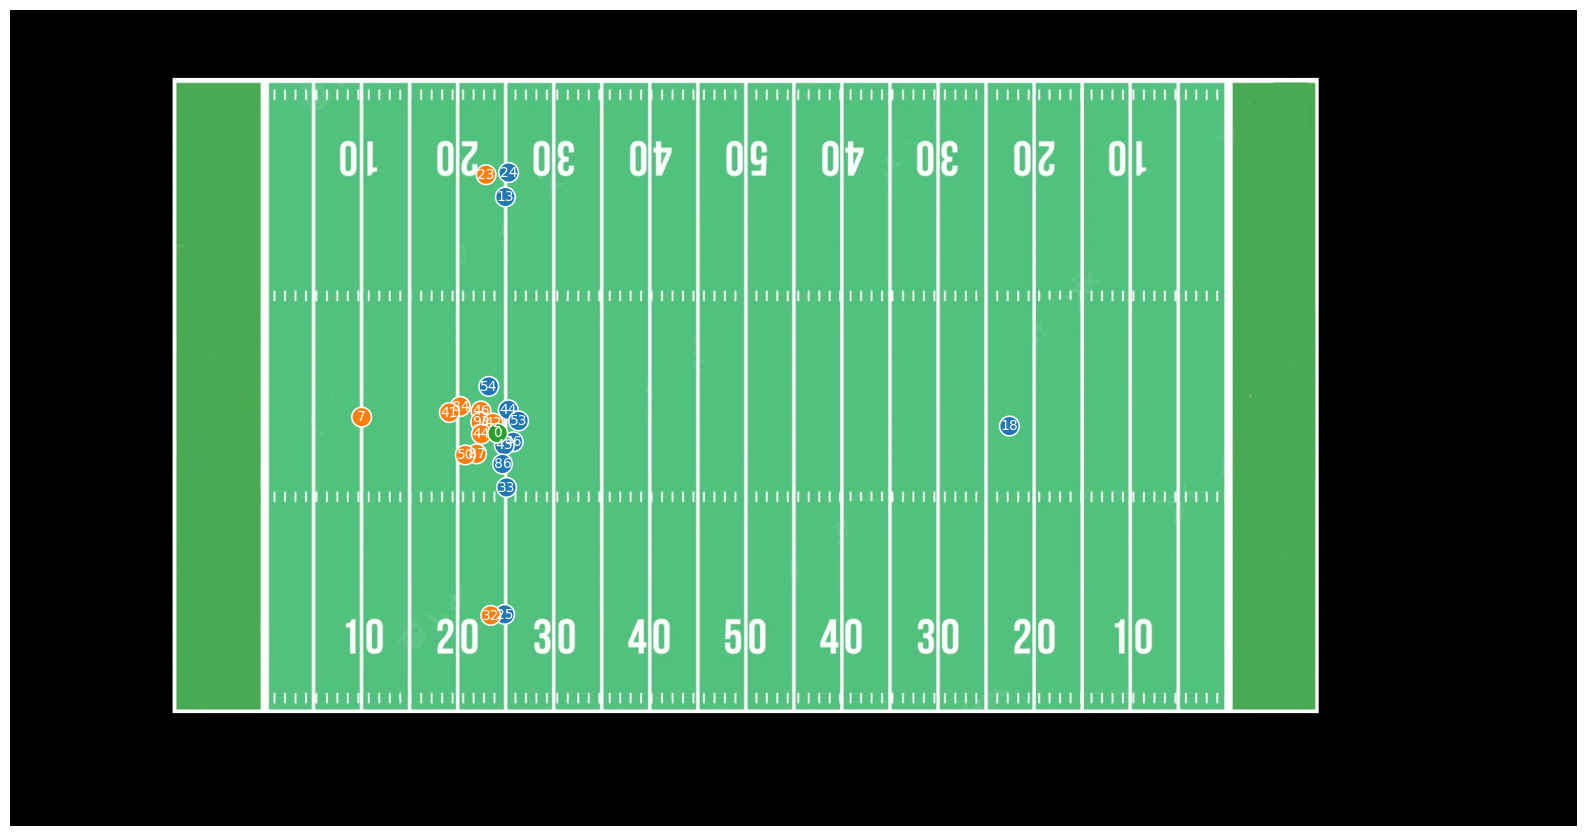

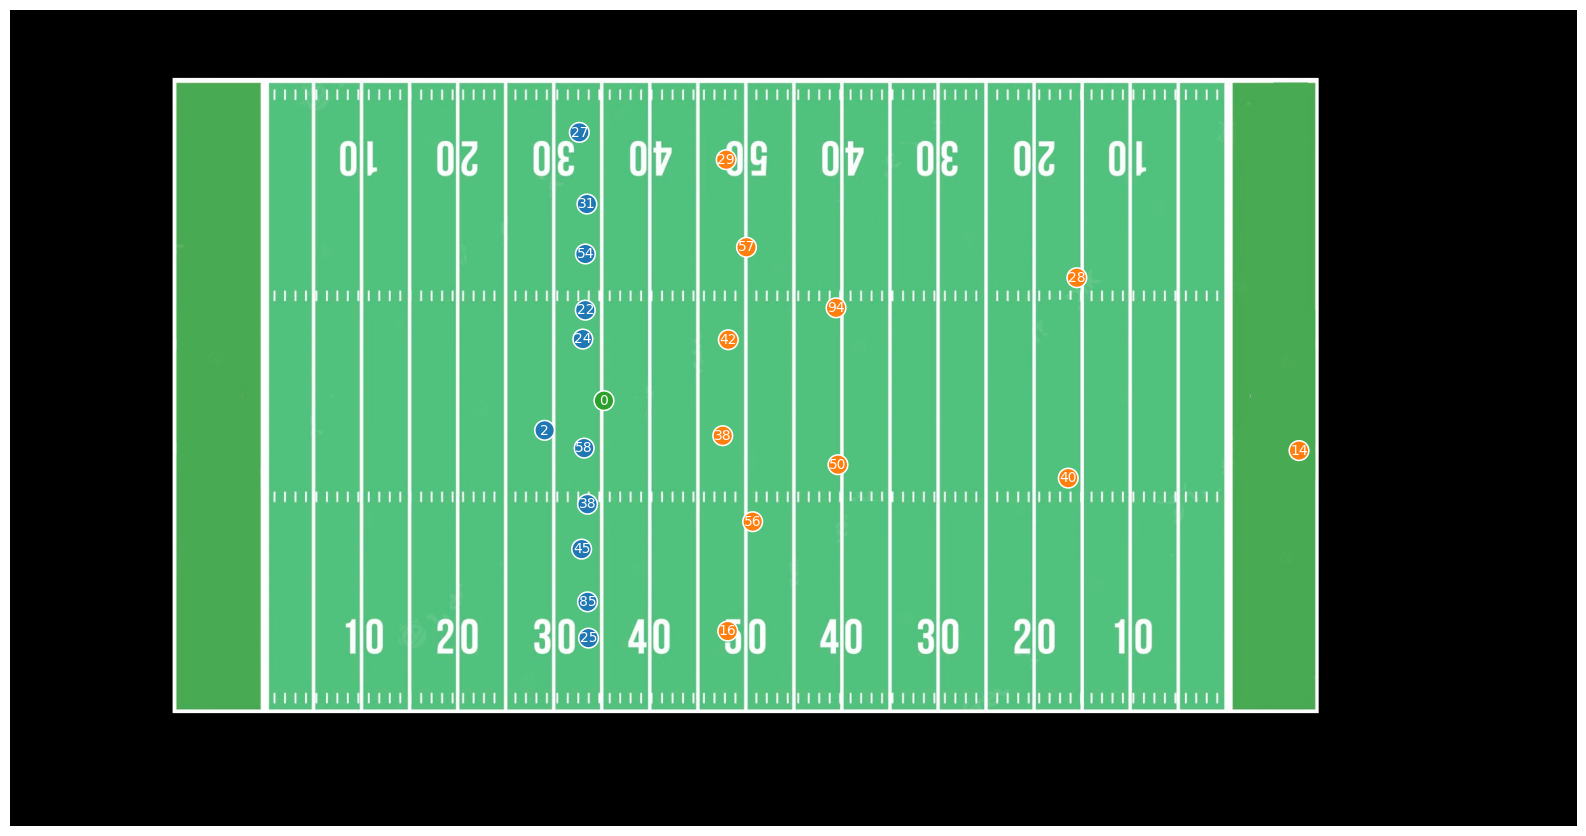

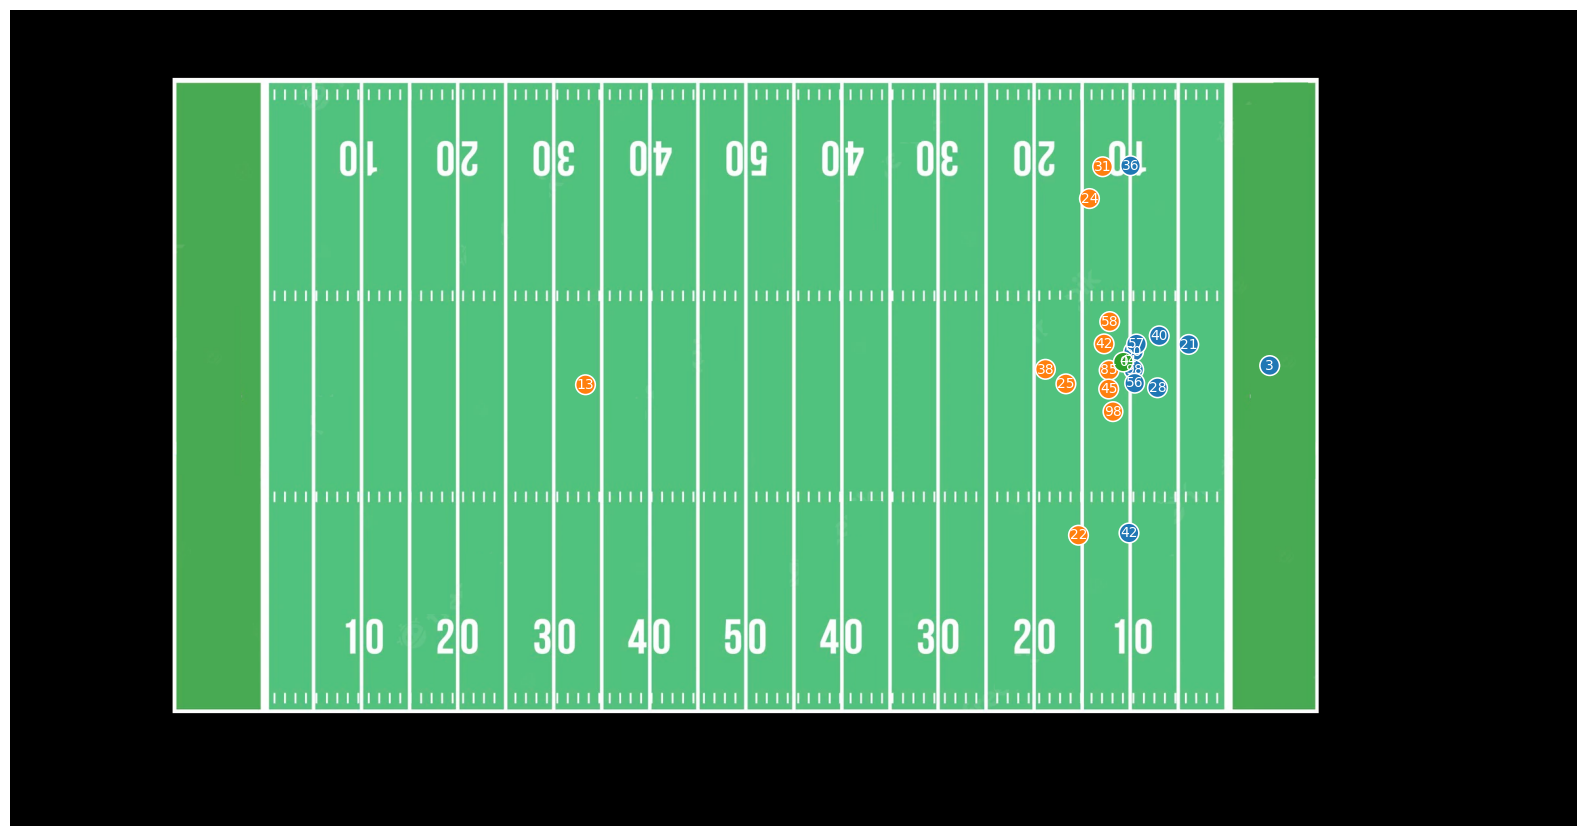

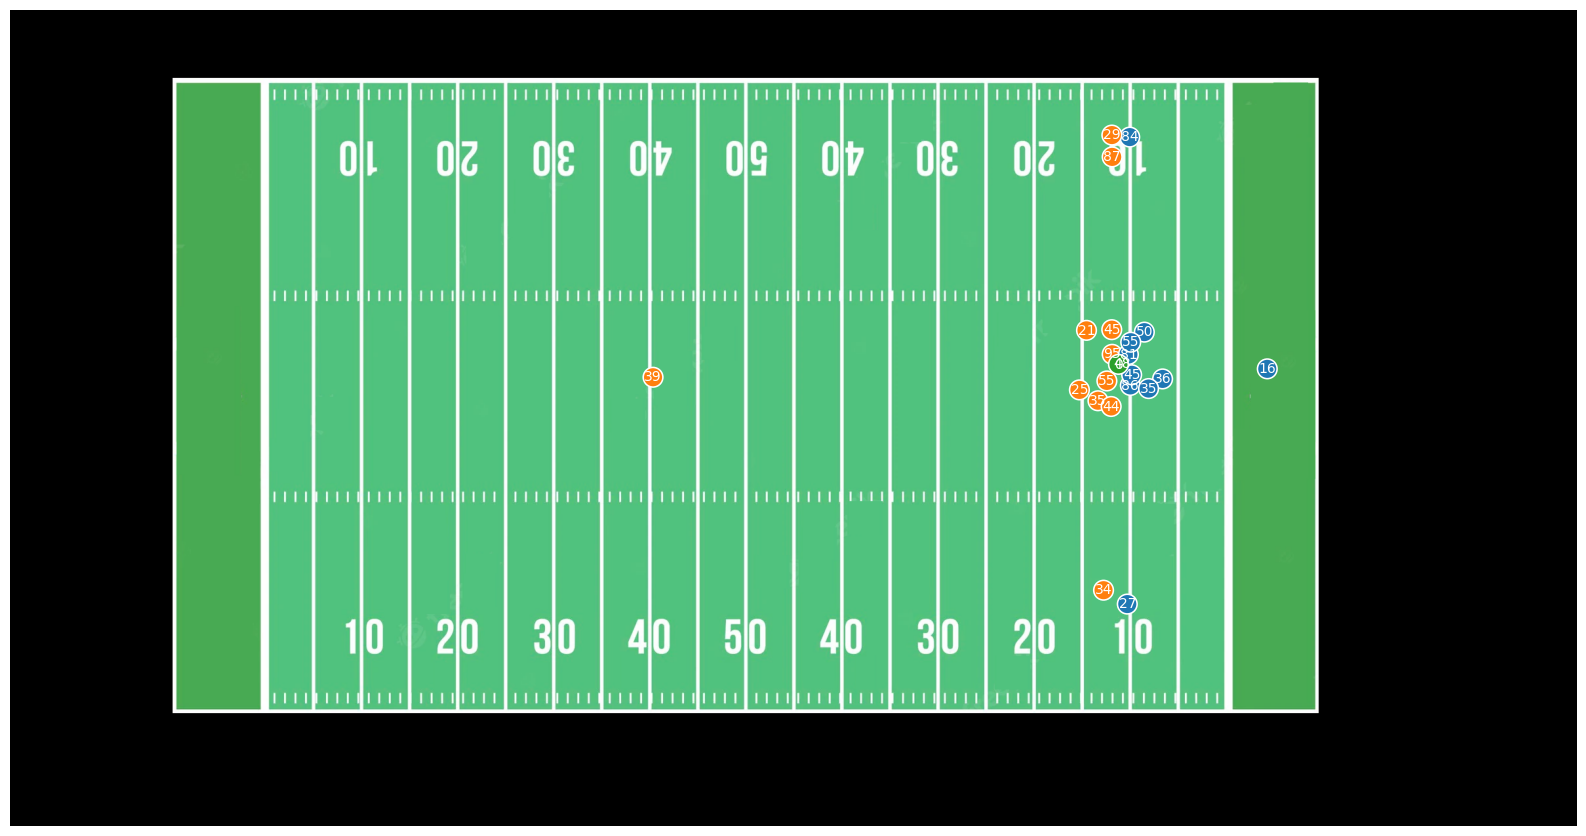

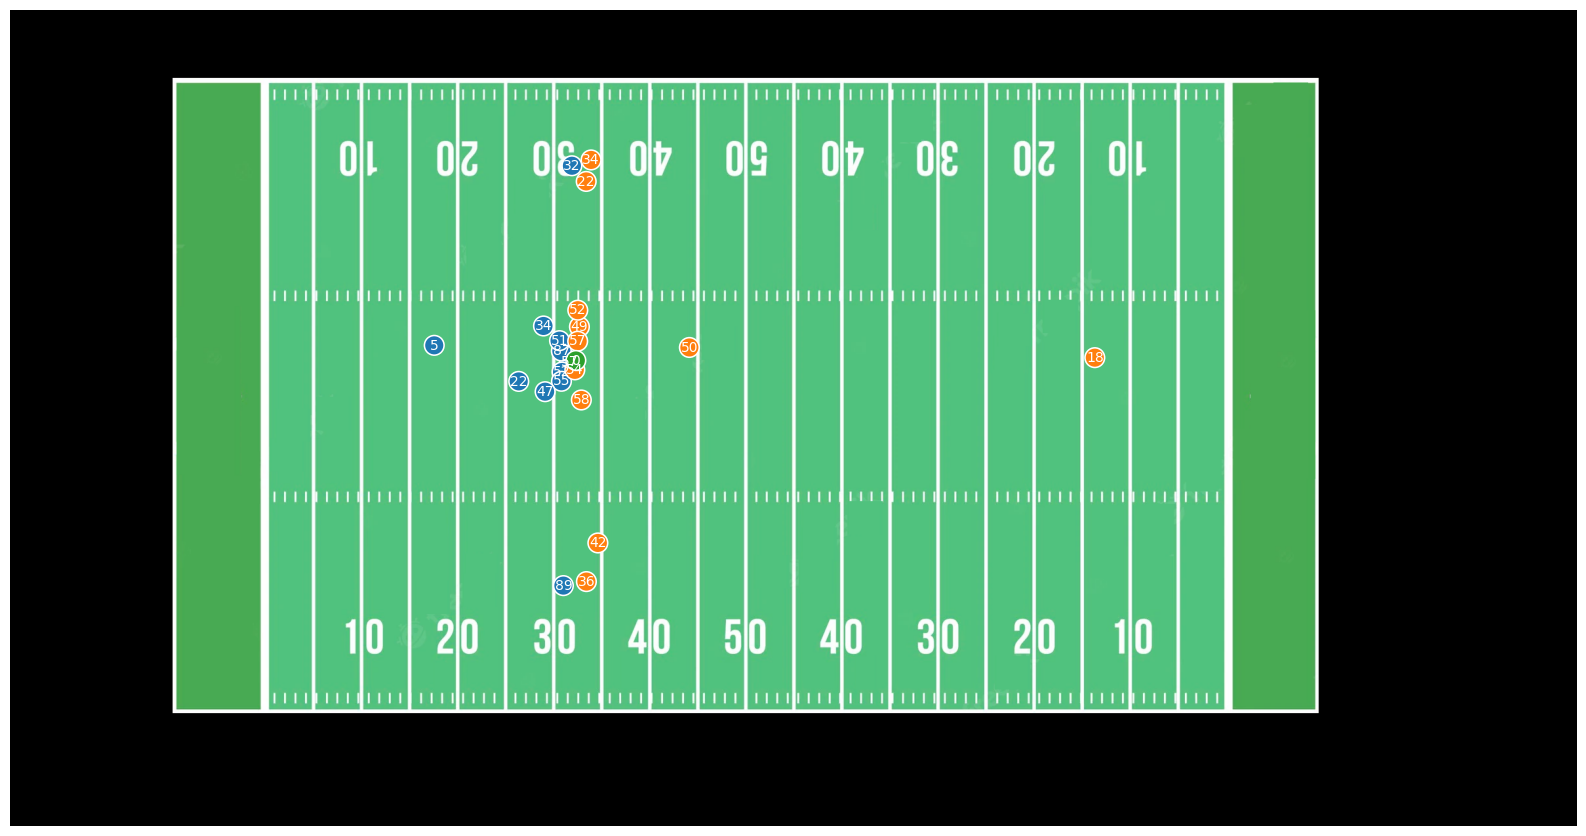

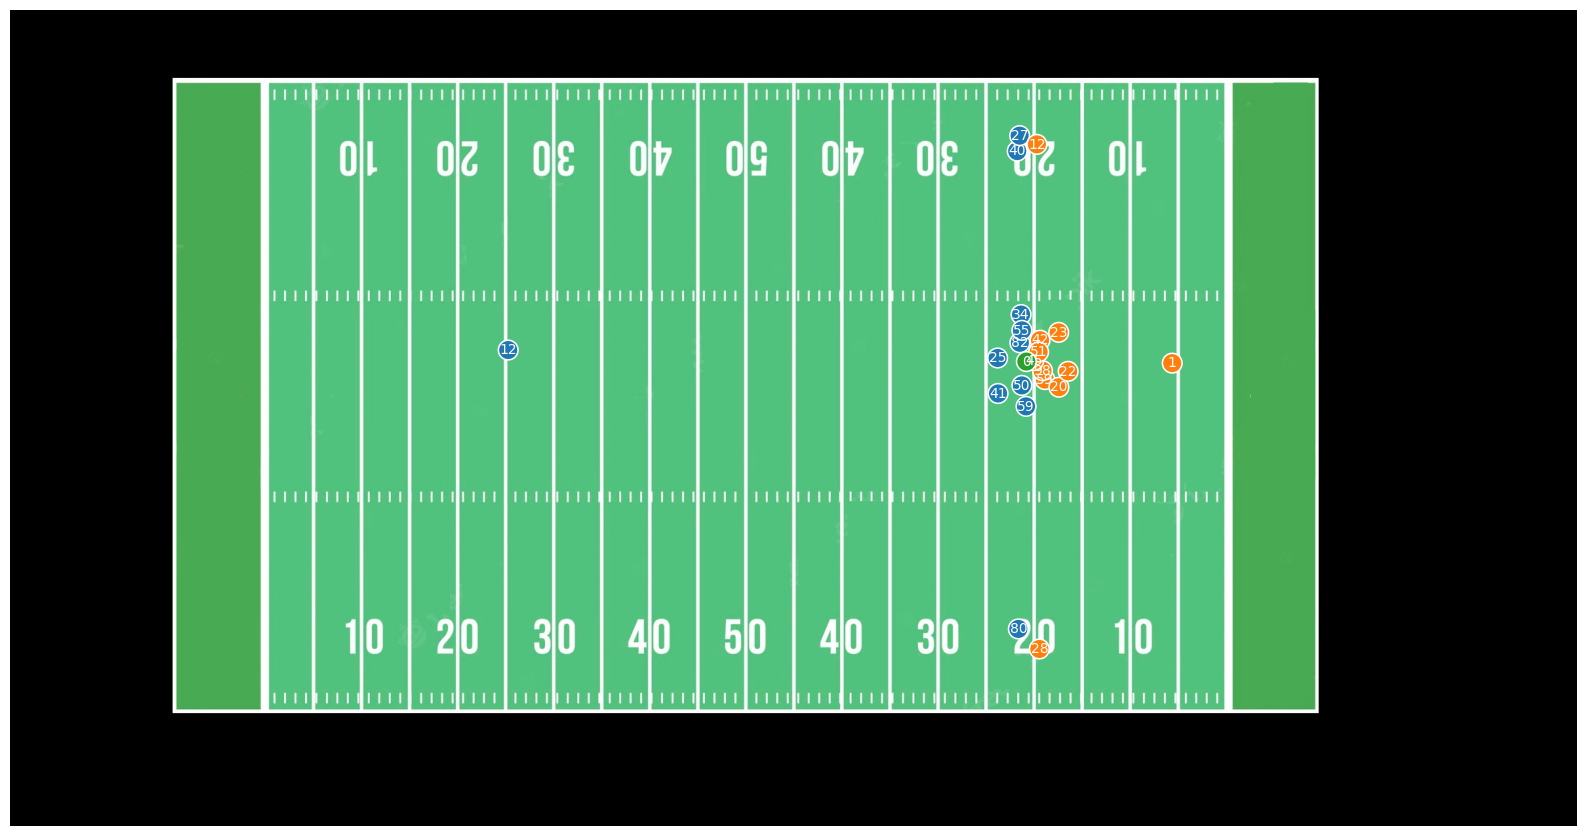

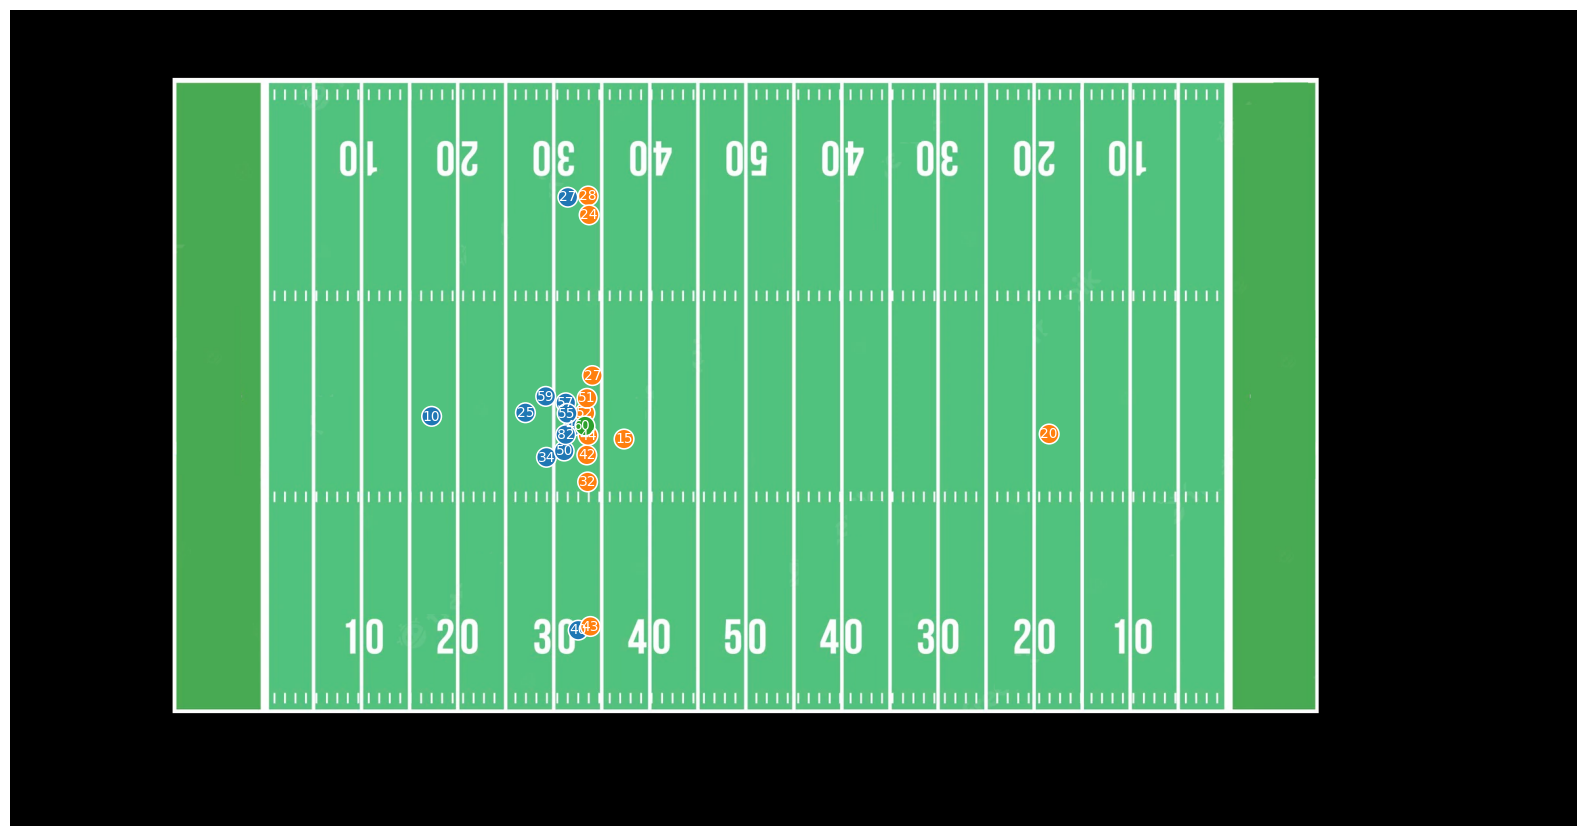

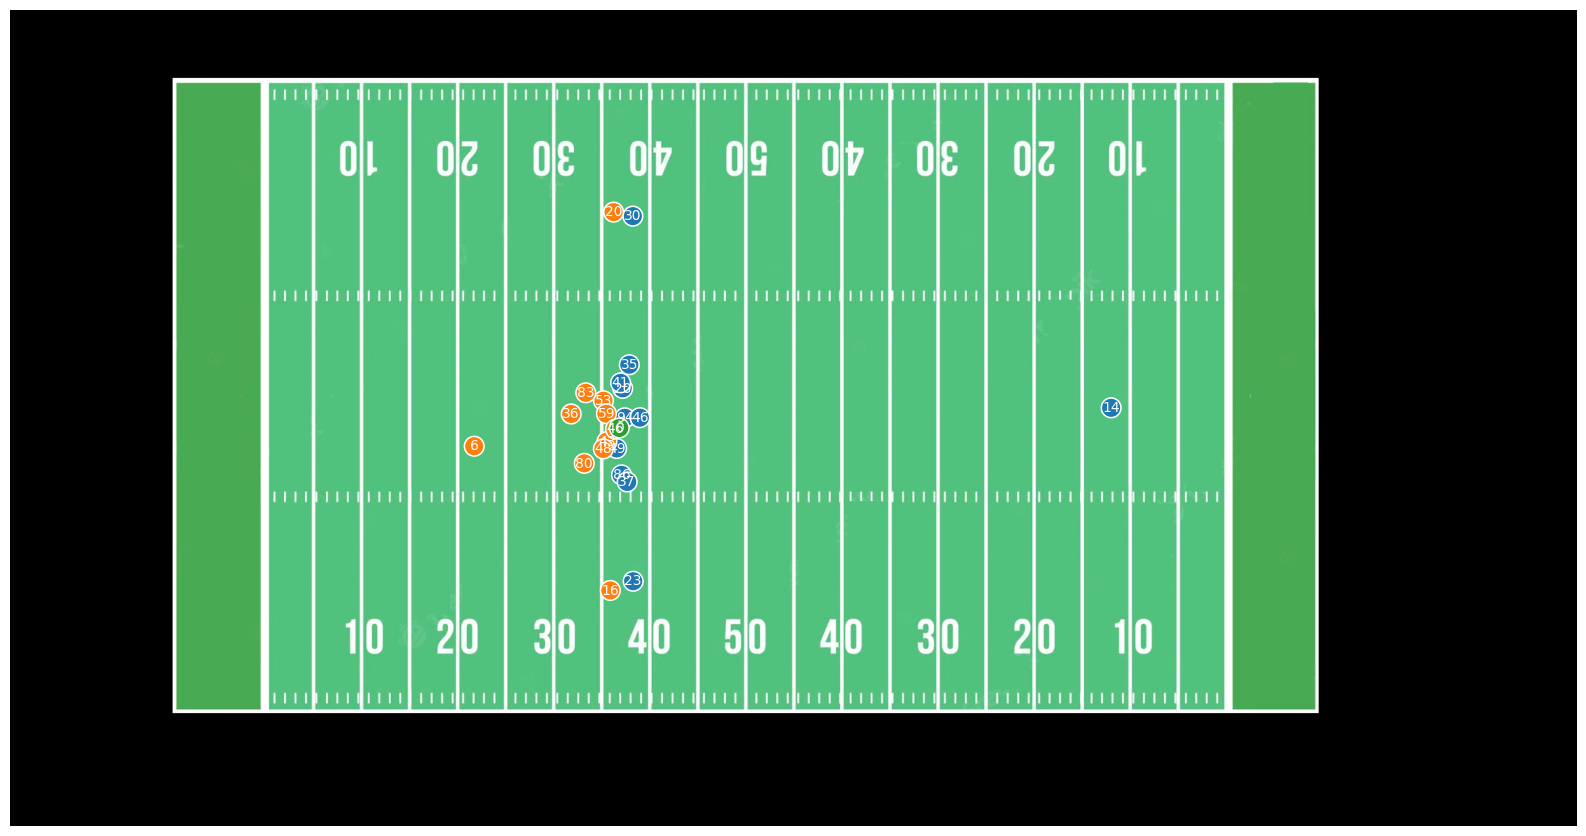

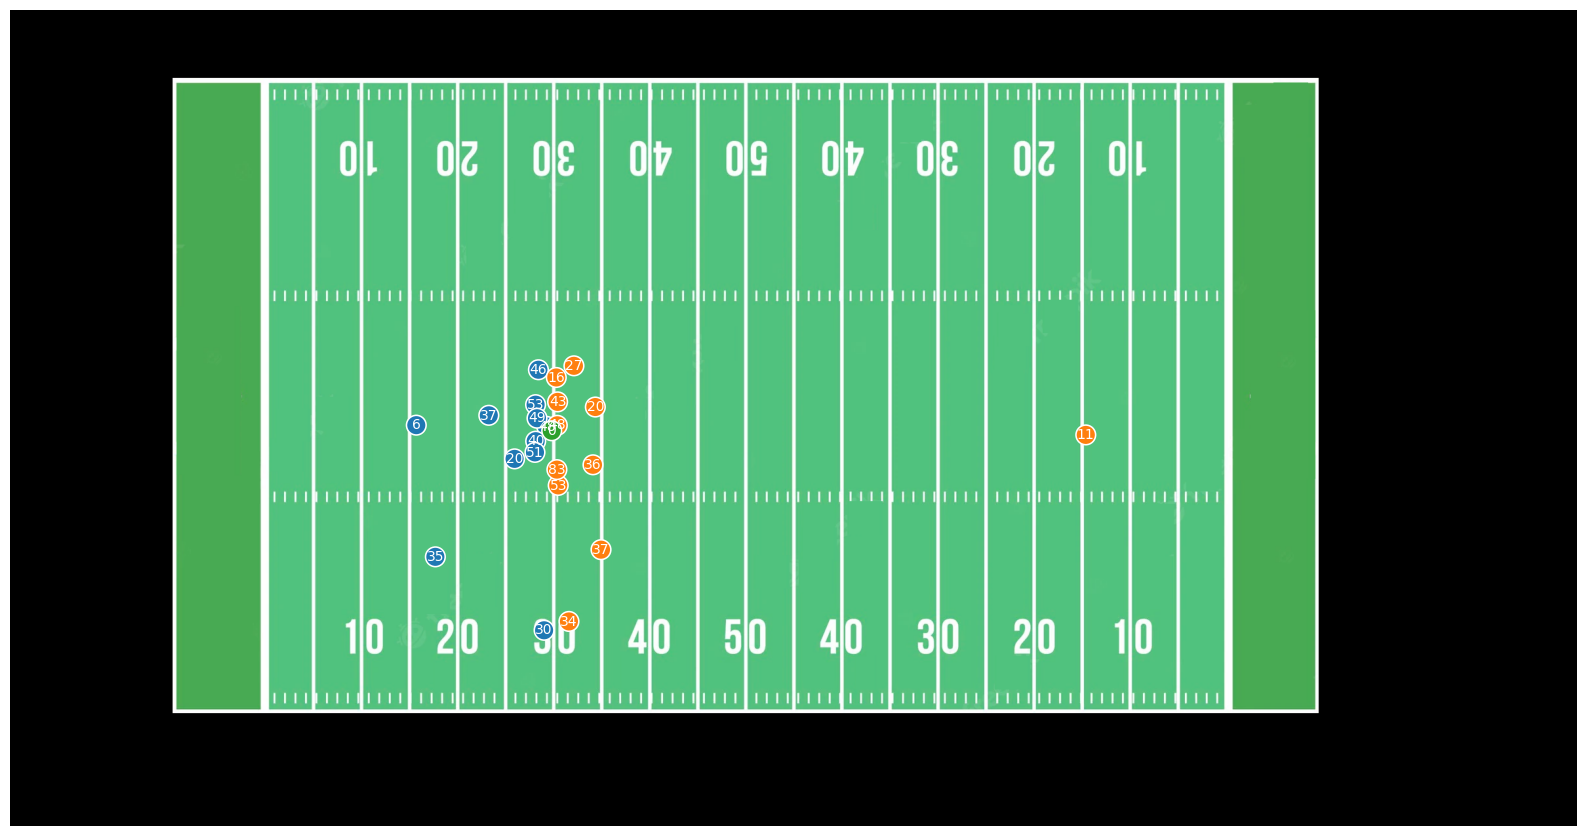

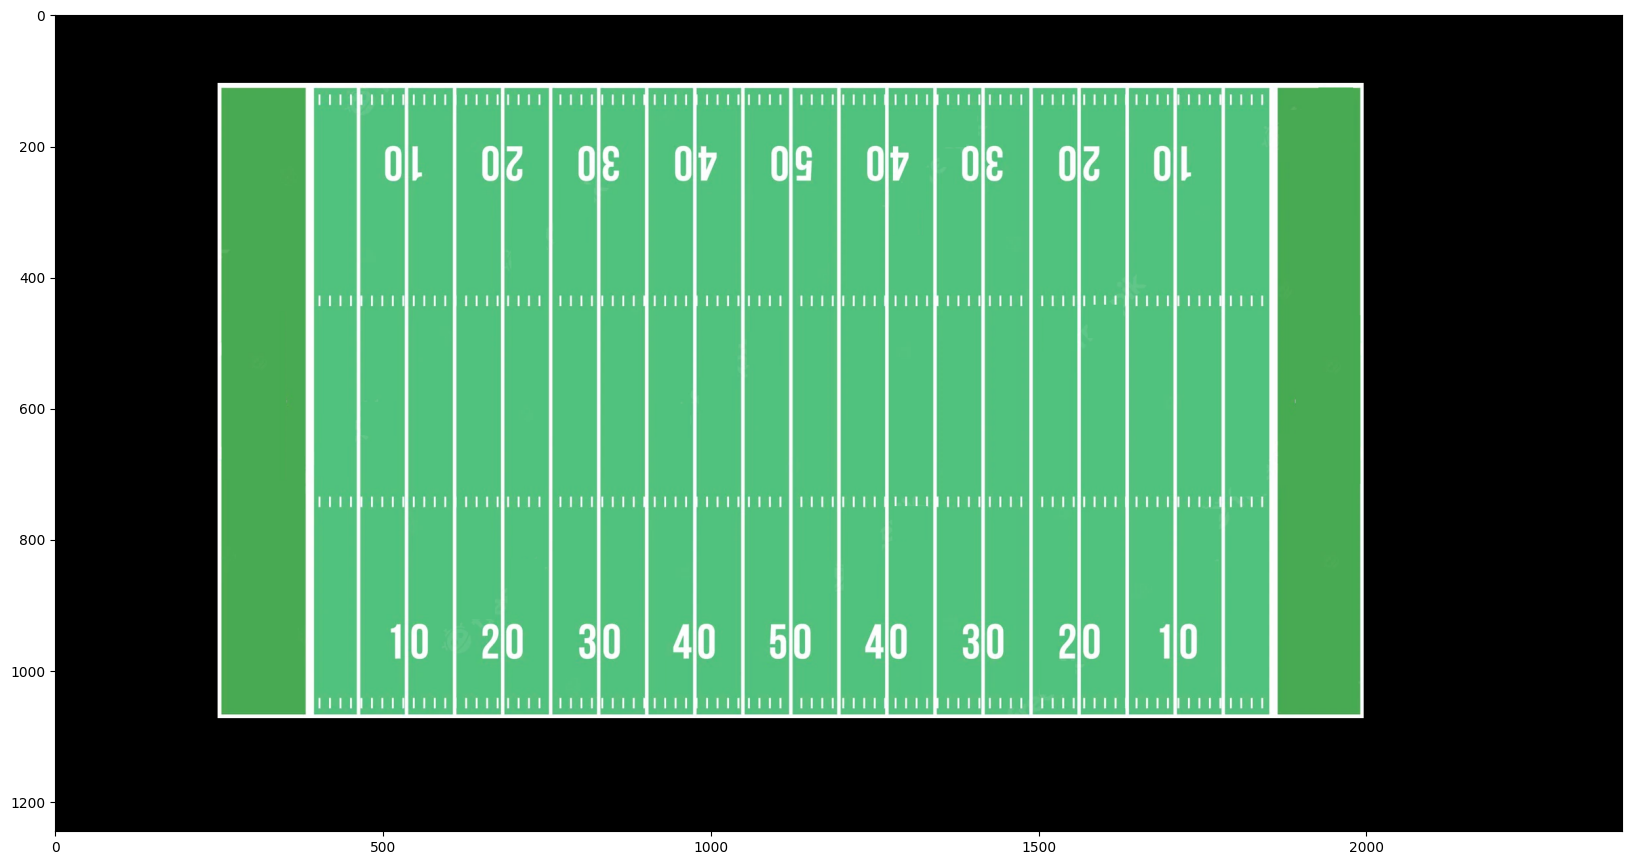

In [56]:
find_all_penalties()

Here are the explanations for the NFL penalty codes you asked about:

- `FMM`: Face Mask (Major). This penalty is called when a player grabs an opponent's face mask in a harmful manner. It results in a 15-yard penalty and an automatic first down if committed by the defense.
- `IBW`: Illegal Block in the Back. This penalty is called when a player hits an opponent in the back outside of close line play. It results in a 10-yard penalty.
- `IDT`: I couldn't find a specific match for this code. It might be best to refer to the official NFL rulebook or contact NFL operations for more information.
- `UNS`: Unsportsmanlike Conduct. This penalty is called for various actions that violate the rules of sportsmanship, such as abusive language or gestures, excessive taunting, or unnecessary physical contact with an official.
- `POK`: I couldn't find a specific match for this code. It might be best to refer to the official NFL rulebook or contact NFL operations for more information.
- `OH`: Offensive Holding. This penalty is called when an offensive player uses his hands, arms, or other parts of his body to prevent a defensive player from pursuing the play. It results in a 10-yard penalty.
- `ITK`: I couldn't find a specific match for this code. It might be best to refer to the official NFL rulebook or contact NFL operations for more information.
- `UNR`: Unnecessary Roughness. This penalty is called when a player uses unnecessarily violent methods to tackle or block another player.
- `DOF`: Delay of Game, Defense. This penalty is called when a defensive player uses tactics that simulate the start of a play (like abrupt movements) to cause an offensive player to false start. It results in a 5-yard penalty.
- `UNRd`: Unnecessary Roughness, Defense. This is similar to Unnecessary Roughness but specifically called on a defensive player.
- `TRP`: Tripping. This penalty is called when a player uses his leg or foot to trip an opponent. It results in a 10-yard penalty.
- `ILF`: Illegal Formation. This penalty is called when the offensive team does not have at least seven players on the line of scrimmage at the snap, among other formation issues. It results in a 5-yard penalty.
- `UNSd`: Unsportsmanlike Conduct, Defense. This is similar to Unsportsmanlike Conduct but specifically called on a defensive player.
- `POK;OH`, `POK;ILF`, `UNRd;ILF`, `FCI;OH`, `OH;IBW`, and `POK;UNR` seem to indicate multiple penalties on a single play. For example, `POK;OH` would mean that both Poking Eyes and Offensive Holding were called on the same play.
- The rest of the codes (`CHB`, `OFK`, `RNK`, `HC`, `KCI`, `UOHd`, `ILH`, `IDP`, `TRPd`, `WED`, `IBB`, `DSQd`, and `IDK`) don't have clear matches based on my current knowledge and available resources.

Please note that these are general explanations and actual enforcement may vary based on specific game situations and league rules. For the most accurate information, it's always best to refer to the official NFL rulebook or contact NFL operations directly.

In [115]:
nfl = NFL()

65.32 -7.58


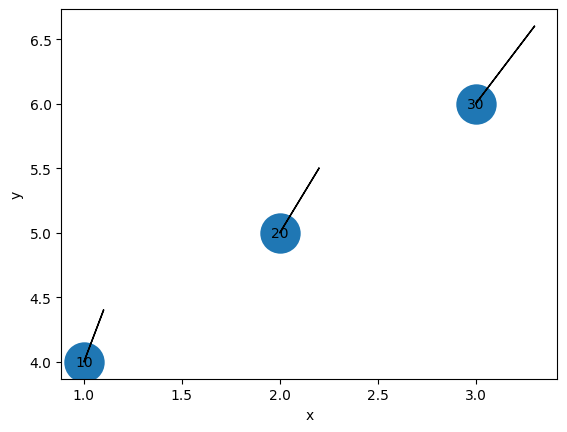

In [ ]:
df = pd.DataFrame({
    'x': [1, 2, 3],
    'y': [4, 5, 6],
    'dx': [0.1, 0.2, 0.3],
    'dy': [0.4, 0.5, 0.6],
    'label': [10, 20, 30]
})

fig, ax = plt.subplots()

# Create the scatter plot with larger points
sns.scatterplot(data=df, x='x', y='y', ax=ax, s=1000)

# Add the labels to the points
for i in range(df.shape[0]):
    ax.text(df['x'].iloc[i], df['y'].iloc[i], str(df['label'].iloc[i]), ha='center', va='center', color='black')

# Add the arrows indicating direction
for i in range(df.shape[0]):
    ax.arrow(df['x'].iloc[i], df['y'].iloc[i], df['dx'].iloc[i], df['dy'].iloc[i])

plt.show()

In [111]:
game_id, play_id = 0, 0
penalties = ["FMM", "IBW", "IDT", "OH", "POK", "UNS"]
penalty = random.choice(penalties)

def play_saved(penalty):
  files = glob.glob(os.path.join("animations/"+penalty+"/", "*.mp4"))
  print(files)
  def getinfo(s):
    if ".mp4" in s:
      s = s.split("/")[-1]
      nm = s.split("_")
      return int(nm[0]), int(nm[1][:-4])
  game_id, play_id = getinfo(random.choice(files))
  with open("animations/"+penalty+"/"+str(game_id)+"_"+str(play_id)+".mp4", "rb") as f:
    video_data = f.read()
    return video_data

HTML("""<video width=800 controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>""".format(b64encode(play_saved(penalty)).decode()))

['animations/IDT/2020091303_1996.mp4']
